In [93]:
#Read in the data from the files.
from mnist import MNIST
import numpy as np
mndata = MNIST('../../HW1/mnist')

trainData, trainLabel = mndata.load_training()

testData, testLabel = mndata.load_testing()

trainData = np.asarray(trainData)
testData = np.asarray(testData)
trainLabel = np.asarray(trainLabel)[:, np.newaxis]
testLabel = np.asarray(testLabel)[:, np.newaxis]

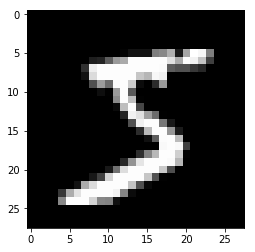

In [94]:
#Show a templete of digits.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time


img = np.reshape(trainData[0],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.show()

In [95]:
def addBias(data):
    bias = np.ones(len(data))[:, np.newaxis]
    biasData = np.concatenate((bias,data), axis=1)
    return biasData

In [128]:
# Process the range of pixel value to [-1..1]
xTrain = trainData / 127.5 - 1
yTrain = trainLabel

xTest = testData / 127.5 - 1
yTest = testLabel

# tack on a "1" at the beginning for a bias parameter
xTrain = addBias(xTrain)
xTest = addBias(xTest)

In [308]:
w_ij = np.zeros((len(xTrain[0]), 64))   #(featuresNum, unitNum)
w_jk = np.zeros((65, 10))   #(unitNum, classNum)
w_ij.shape

(785, 64)

In [372]:
xTrainB = xTrain[:10]
xTrainB

array([[ 1., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.],
       ..., 
       [ 1., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.]])

In [379]:
xTrainBMean = np.mean(xTrainB, axis = 0)[np.newaxis, :]

In [380]:
xTrainB - xTrainBMean

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [389]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def calculateLoss(data, label, w1, w2, lam):
    a_j = data.dot(w1)
    ga_j = sigmoid(a_j)
    a_k = addBias(ga_j).dot(w2)
    ga_k = np.exp(a_k) / np.sum(np.exp(a_k), axis=1)[:, np.newaxis]
    E = -1.0 * np.mean(label * np.log(ga_k))
    #C = np.sum(np.power(weight, 2))
    #loss = E + lam * C
    loss = E
    return loss

def oneHiddenLayer(trainData, trainLabel, lr = 1e-1, maxIter = 500, T = 2e8, lam = 1e-3, batchSize = 1, unitNum = 64):
    classNum = len(np.unique(trainLabel))
    trainLabel = oneHot(trainLabel)
    trainD, validD, trainL, validL = train_test_split(trainData, trainLabel, test_size=0.2, random_state=42)    
    w_ij = np.zeros((len(trainD[0]), unitNum))
    w_jk = np.zeros((unitNum + 1, classNum))
    index = np.arange(len(trainD))
    it = 0    
    while it <= maxIter:
        np.random.shuffle(index)
        lr1 = lr / (1.0 + it / T)
        # Gradient Descent
        for startInd in range(0, len(trainData) - batchSize + 1, batchSize):
            trainDBatch = trainD[index[startInd : startInd + batchSize]]
            #trainDMean = np.mean(trainDBatch, axis = 0)[np.newaxis, :]
            #trainDBatch = trainDBatch - trainDMean
            trainLBatch = trainL[index[startInd : startInd + batchSize]]
            a_j = trainDBatch.dot(w_ij)   #(batchSize, unitNum) 

            ga_j = sigmoid(a_j)   #(batchSize, unitNum)
            ga_j = addBias(ga_j) 
            
            a_k = ga_j.dot(w_jk)   #(batchSize, classNum)

            ga_k = np.exp(a_k) / np.sum(np.exp(a_k), axis=1)[:, np.newaxis]   #(batchSize, classNum)

            derGa_j = ga_j * (1 - ga_j)   #(batchSize, unitNum)

            delta_k = trainLBatch - ga_k   #(batchSize, classNum)
            
            delta_j = (derGa_j * (delta_k.dot(w_jk.T)))[:,1:]   #(batchSize, unitNum)
            
            w_ij = w_ij + lr1 * trainDBatch.T.dot(delta_j) / batchSize   #(featuresNum, unitNum)
            
            w_jk = w_jk + lr1 * ga_j.T.dot(delta_k) / batchSize   #(unitNum, classNum)

        lossV = calculateLoss(validD, validL, w_ij, w_jk, lam)
        if it % 10 == 0:
            print (lossV)
        it += 1
    print ('done')
    return w_ij, w_jk

In [390]:
w_ij, w_jk = oneHiddenLayer(xTrain, yTrain, lr = 1e-0, batchSize = int(len(xTrain) / 100))

0.195805614158
0.0616952183605
0.0524029124967
0.0621871636785
0.0474895767682
0.0549403138559
0.0503692556052
0.0466224717983
0.0467673228287
0.0492242556456
0.0459807183656
0.0474695789354
0.0472149326568
0.0471399661684
0.0460382917607
0.0458683596313
0.0487997570849
0.0468022916045
0.046905221414
0.0621152997349
0.0462132350224
0.0466730060055
0.0482347907558
0.0467715446366
0.0484416885629
0.0473079145111
0.0479059198034
0.0470280730662
0.047396530812
0.0478720643844
0.0465603973583
0.0488019356052
0.0474081171904
0.0498292057308
0.0477904384944
0.0480305974339
0.0464173953531
0.0487484730229
0.0475925233904
0.0461765146641
0.0470829614626
0.0483541530714
0.0462511387104
0.0464873505135
0.0472668769964
0.0468797990181
0.0484376133475
0.0467987769809
0.050241804842
0.0472704560286
0.0471059663834
done


In [391]:
def pecisionRate(data, label, w1, w2):
    correct = 0
    label = oneHot(label)
    for i in range(len(data)):
        a_j = data[i][np.newaxis,:].dot(w1)
        ga_j = sigmoid(a_j)
        a_k = addBias(ga_j).dot(w2)
        ga_k = (np.exp(a_k) / np.sum(np.exp(a_k), axis=1)[:, np.newaxis])[0]
        prediction = np.where(ga_k == np.max(ga_k))[0][0]
        if label[i, prediction] == 1:
            correct += 1
    rate = 1.0 * correct / len(label)
    return rate

In [392]:
acc = pecisionRate(xTest, yTest, w_ij, w_jk)
acc

0.8692

In [433]:
a_j = xTest[0][np.newaxis,:].dot(w_ij)
a_j.shape

(1, 64)

In [434]:
ga_j = sigmoid(a_j)
ga_j

array([[  8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
          8.69569171e-01,   8.69569171e-01,   8.69569171e-01,
        

In [435]:
a_k = addBias(ga_j).dot(w_jk)
a_k

array([[ -4.30828055,   3.12673913,   6.84109744,   6.39412778,
         -9.56782482,  -4.07082743, -10.98520887,  11.85729285,
         -1.38986683,   2.1027513 ]])

In [436]:
ga_k = (np.exp(a_k) / np.sum(np.exp(a_k), axis=1)[:, np.newaxis])[0]
ga_k

array([  9.43170612e-08,   1.59800553e-04,   6.55697608e-03,
         4.19360132e-03,   4.90229232e-10,   1.19595500e-07,
         1.18805660e-10,   9.89030268e-01,   1.74598792e-06,
         5.73939371e-05])

In [437]:
prediction = np.where(ga_k == np.max(ga_k))[0][0]
prediction

7

In [438]:
yTest[0]

array([7], dtype=uint8)

In [309]:
a_j = xTrain[:5].dot(w_ij)   #(batchSize, unitNum) 

ga_j = sigmoid(a_j)   #(batchSize, unitNum)

a_k = addBias(ga_j).dot(w_jk)   #(batchSize, classNum)

ga_k = np.exp(a_k) / np.sum(np.exp(a_k), axis=1)[:, np.newaxis]   #(batchSize, classNum)

derGa_j = ga_j * (1 - ga_j)   #(batchSize, unitNum)

delta_k = yTrHot[:5] - ga_k   #(batchSize, classNum)

delta_j = derGa_j * (delta_k.dot(w_jk.T))[:,1:]   #(batchSize, unitNum)

w_ij = w_ij + 1e-3 * xTrain[:5].T.dot(delta_j) / batchSize   #(featuresNum, unitNum)

w_jk = w_jk + 1e-3 * ga_j.T.dot(delta_k) / batchSize   #(unitNum, classNum)


NameError: name 'batchSize' is not defined

# Logistic Regression via Gradient Descent

In [37]:
# Define data extraction function
def dataExtract(data, label, target1, target2):
    indexTg1 = np.where(label == target1)[0]
    dataTg1 = data[indexTg1]
    labelTg1 = np.ones(len(indexTg1))[:,np.newaxis]
    indexTg2 = np.where(label == target2)[0]
    dataTg2 = data[indexTg2]
    labelTg2 = np.zeros(len(indexTg2))[:,np.newaxis]
    dataEx = np.concatenate((dataTg1,dataTg2), axis = 0)
    labelEx = np.concatenate((labelTg1,labelTg2), axis = 0)
    return dataEx, labelEx

xTrain28, yTrain28 = dataExtract(xTrain, yTrain, 2, 8)
xTest28, yTest28 = dataExtract(xTest, yTest, 2, 8)

In [66]:
from sklearn.model_selection import train_test_split

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def calculateLossLR(data, label, weight, lam):
    E = -1.0 * np.mean(label * np.log(sigmoid(np.dot(data, weight)))\
                         + (1 - label) * np.log(1 - sigmoid(np.dot(data, weight))))
    C = np.sum(np.power(weight, 2))
    loss = E + lam * C
    return loss

def logisticRegression(trainData, trainLabel, lr = 1e-3, maxIter = 500, T = 2e8, lam = 1e-3, batchSize = 1):
    trainD, validD, trainL, validL = train_test_split(trainData, trainLabel, test_size=0.1, random_state=42)        
    w_0 = np.zeros((len(trainD[0]), 1))
    it = 0
    while it <= maxIter:
        lr1 = lr / (1.0 + it / T)
        for startInd in range(0, len(trainData) - batchSize + 1, batchSize):
            trainDBatch = trainD[startInd : startInd + batchSize]
            trainLBatch = trainL[startInd : startInd + batchSize]
            derE = np.mean((sigmoid(np.dot(trainDBatch, w_0)) - trainLBatch) \
                          * trainDBatch, axis = 0)[:, np.newaxis]
            derC = 2.0 * np.sum(w_0)
            derJ = derE + lam * derC
            w_0 -= lr1 * derJ
        loss = calculateLossLR(validD, validL, w_0, lam)
        if it % 100 == 0:
            print(loss)
        it += 1
    return w_0

In [73]:
weight = logisticRegression(xTrain28, yTrain28, 1.5e-2, 1000, lam = 1e-4, batchSize = int(len(xTrain28) / 10))

0.429911105598
0.0844853103409
0.0793186686404
0.0777809370218
0.0771583228958
0.0768908884076
0.0767985002534
0.0768065973458
0.0768783603732
0.0769931182047
0.0771381333187


In [74]:
def pecisionRate(data, label, weight):
    pred = sigmoid(np.dot(data, weight))
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    rate = 1.0 * np.sum([a == b for (a, b) in zip(pred, label)]) / len(label)
    return rate

acc = pecisionRate(xTest28, yTest28, weight)
acc

0.98055832502492524

In [311]:
from sklearn.model_selection import train_test_split
def calculateLoss(data, label, weight, lam):
    a = data.dot(weight)
    y = np.exp(a) / np.sum(np.exp(a), axis=1)[:, np.newaxis]
    E = -1.0 * np.mean(label * np.log(y))
    C = np.sum(np.power(weight, 2))
    loss = E + lam * C
    return loss

def oneHot(label):
    labelHot = np.zeros((len(label),len(np.unique(label))))
    for i in range(len(label)):
        labelHot[i,label[i]] = 1
    return labelHot

def softmaxRegression(trainData, trainLabel, lr = 1e-4, maxIter = 500, T = 2e8, lam = 1e-3, batchSize = 1):
    classNum = len(np.unique(trainLabel))
    trainLabel = oneHot(trainLabel)
    trainD, validD, trainL, validL = train_test_split(trainData, trainLabel, test_size=0.1, random_state=42)    
    w_0 = np.zeros((len(trainData[0]), classNum))
    it = 0    
    while it <= maxIter:
        lr1 = lr / (1.0 + it / T)
        # Gradient Descent
        for startInd in range(0, len(trainData) - batchSize + 1, batchSize):
            trainDBatch = trainD[startInd : startInd + batchSize]
            trainLBatch = trainL[startInd : startInd + batchSize]
            a = trainDBatch.dot(w_0)
            y = np.exp(a) / np.sum(np.exp(a), axis=1)[:, np.newaxis]
            y = y - trainLBatch        
            derE = 1.0 * trainDBatch.T.dot(y) / batchSize
            derC = 2.0 * np.sum(w_0)
            derJ = derE + lam * derC
            w_0 -= lr1 * derJ
        lossV = calculateLoss(validD, validL, w_0, lam)
        if it % 100 == 0:
            print (lossV)
        it += 1
    print ('done')
    return w_0

In [63]:
weight = softmaxRegression(xTrain, yTrain, 1.75e-1, 700, lam = 1e-4, batchSize = int(len(xTrain) / 10))

1.44450540388
0.0337977770761
0.033913156151
0.0446888522617
0.035740750449
0.0368835198606
0.0660028793269
0.0381598880233
done


In [64]:
def pecisionRate(data, label, weight):
    correct = 0
    label = oneHot(label)
    for i in range(len(data)):
        a = data[i][np.newaxis,:].dot(weight)
        y = (np.exp(a) / np.sum(np.exp(a)))[0]
        prediction = np.where(y == np.max(y))[0][0]
        if label[i, prediction] == 1:
            correct += 1
    rate = 1.0 * correct / len(label)
    return rate

In [65]:
yTeHot = oneHot(yTest)
acc = pecisionRate(xTest, yTest, weight)
acc

0.9239

In [297]:
yTrHot = oneHot(yTrain)